In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

print("LFP Battery Data Visualization")

# Alle discharge CSV-Dateien laden
processed_path = Path("../data/processed")
discharge_files = list(processed_path.glob("*_discharge.csv"))

# Wichtige Batterien für Visualisierung auswählen
key_batteries = {
    'B0005': 'Source (high degradation)',
    'B0006': 'Source (high degradation)', 
    'B0025': 'Target (low degradation)',
    'B0030': 'Target (low degradation)',
    'B0033': 'Mixed (special case)'
}

battery_data = {}

for battery_id, description in key_batteries.items():
    csv_file = processed_path / f"{battery_id}_discharge.csv"
    if csv_file.exists():
        df = pd.read_csv(csv_file)
        capacity_per_cycle = df.groupby('id_cycle')['Capacity'].last().reset_index()
        capacity_per_cycle['cycle'] = capacity_per_cycle['id_cycle'] + 1
        
        battery_data[battery_id] = {
            'capacity_data': capacity_per_cycle['Capacity'].values,
            'cycles': len(capacity_per_cycle),
            'description': description
        }
        
        print(f"{battery_id}: {len(capacity_per_cycle)} Zyklen ({description})")



LFP Battery Data Visualization
B0005: 168 Zyklen (Source (high degradation))
B0006: 168 Zyklen (Source (high degradation))
B0025: 28 Zyklen (Target (low degradation))
B0030: 40 Zyklen (Target (low degradation))
B0033: 197 Zyklen (Mixed (special case))


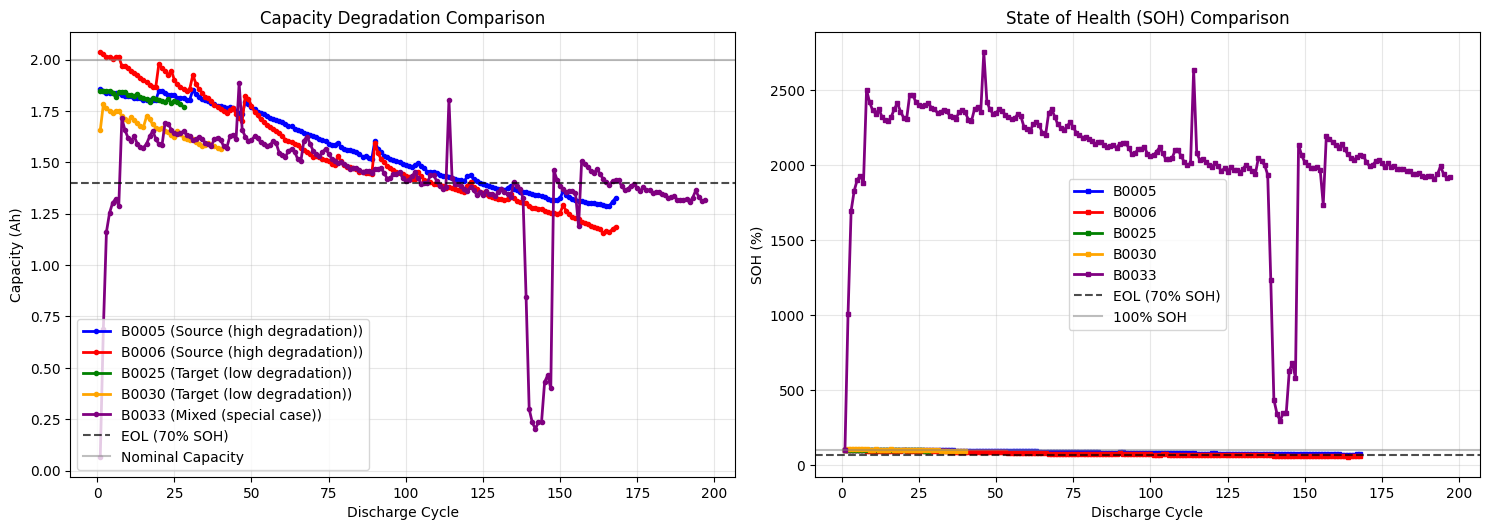

In [3]:
# Degradationskurven aller wichtigen Batterien
plt.figure(figsize=(15, 10))

# Subplot 1: Alle Degradationskurven
plt.subplot(2, 2, 1)
colors = ['blue', 'red', 'green', 'orange', 'purple']

for i, (battery_id, data) in enumerate(battery_data.items()):
    capacity = data['capacity_data']
    cycles = range(1, len(capacity) + 1)
    
    plt.plot(cycles, capacity, 
             color=colors[i], linewidth=2, marker='o', markersize=3,
             label=f"{battery_id} ({data['description']})")

# EOL Linie bei 1.4 Ah
plt.axhline(y=1.4, color='black', linestyle='--', alpha=0.7, label='EOL (70% SOH)')
plt.axhline(y=2.0, color='gray', linestyle='-', alpha=0.5, label='Nominal Capacity')

plt.title('Capacity Degradation Comparison')
plt.xlabel('Discharge Cycle')
plt.ylabel('Capacity (Ah)')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Normalisierte Degradation (SOH)
plt.subplot(2, 2, 2)

for i, (battery_id, data) in enumerate(battery_data.items()):
    capacity = data['capacity_data']
    cycles = range(1, len(capacity) + 1)
    
    # SOH berechnen
    initial_capacity = capacity[0]
    soh = (capacity / initial_capacity) * 100
    
    plt.plot(cycles, soh, 
             color=colors[i], linewidth=2, marker='s', markersize=3,
             label=f"{battery_id}")

plt.axhline(y=70, color='black', linestyle='--', alpha=0.7, label='EOL (70% SOH)')
plt.axhline(y=100, color='gray', linestyle='-', alpha=0.5, label='100% SOH')

plt.title('State of Health (SOH) Comparison')
plt.xlabel('Discharge Cycle')
plt.ylabel('SOH (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

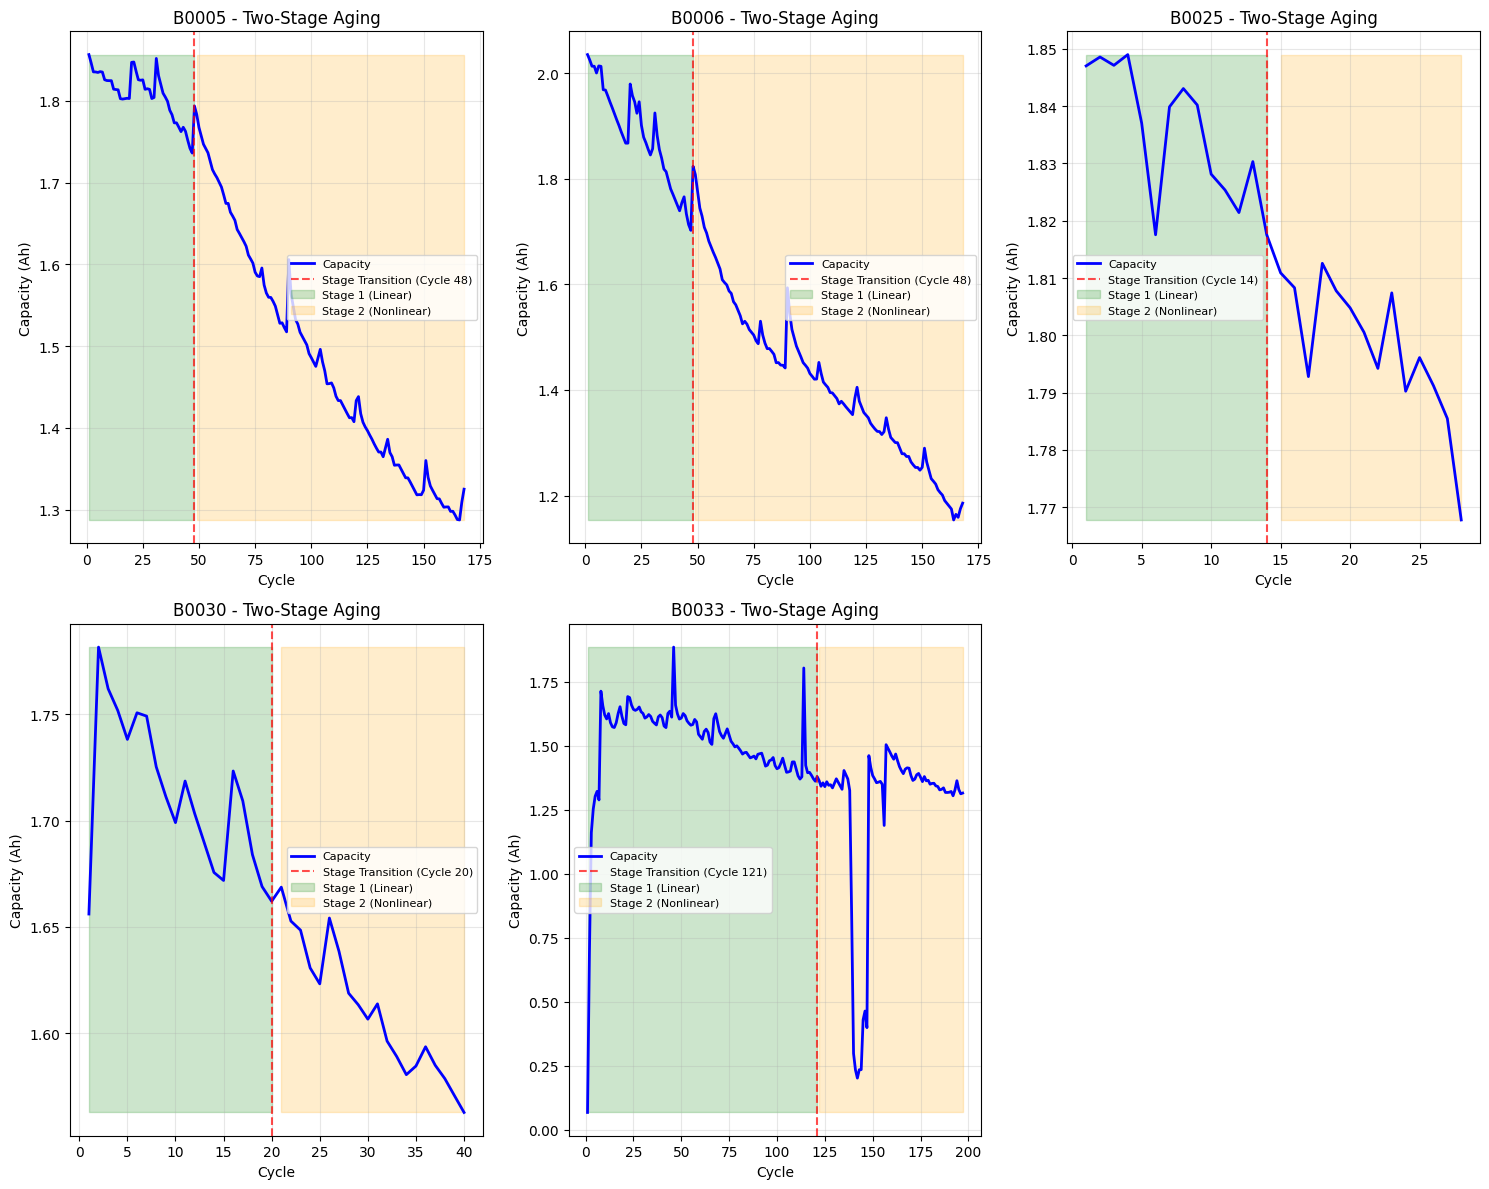

TWO-STAGE TRANSITION ANALYSIS:
--------------------------------------------------
B0005: Transition at cycle 48 (28.6% of life)
   Total Degradation: 28.6%
   Stage 1: 48 cycles, Stage 2: 120 cycles

B0006: Transition at cycle 48 (28.6% of life)
   Total Degradation: 41.7%
   Stage 1: 48 cycles, Stage 2: 120 cycles

B0025: Transition at cycle 14 (50.0% of life)
   Total Degradation: 4.3%
   Stage 1: 14 cycles, Stage 2: 14 cycles

B0030: Transition at cycle 20 (50.0% of life)
   Total Degradation: 5.6%
   Stage 1: 20 cycles, Stage 2: 20 cycles

B0033: Transition at cycle 121 (61.4% of life)
   Total Degradation: -1822.2%
   Stage 1: 121 cycles, Stage 2: 76 cycles



In [4]:
# Two-Stage Aging Pattern Analysis
def detect_stage_transition(capacity_data, window=20):
    """Erkennt Übergang von linearer zu nonlinearer Degradation"""
    
    if len(capacity_data) < window * 2:
        return len(capacity_data) // 2
    
    # Degradationsrate in gleitenden Fenstern
    degradation_rates = []
    for i in range(window, len(capacity_data) - window):
        rate1 = abs(np.mean(np.diff(capacity_data[i-window:i])))
        rate2 = abs(np.mean(np.diff(capacity_data[i:i+window])))
        degradation_rates.append(rate2 - rate1)
    
    # Punkt mit größter Änderung der Degradationsrate
    if degradation_rates:
        change_point = np.argmax(degradation_rates) + window
        return min(change_point, len(capacity_data) - 1)
    
    return len(capacity_data) // 2

# Two-Stage Analysis für alle Batterien
plt.figure(figsize=(15, 12))

for idx, (battery_id, data) in enumerate(battery_data.items()):
    capacity = data['capacity_data']
    cycles = range(1, len(capacity) + 1)
    
    # Stage Transition Point
    transition_point = detect_stage_transition(capacity)
    
    plt.subplot(2, 3, idx + 1)
    
    # Degradationskurve
    plt.plot(cycles, capacity, 'b-', linewidth=2, label='Capacity')
    
    # Stage 1 und Stage 2 markieren
    if transition_point < len(capacity):
        plt.axvline(x=transition_point, color='red', linestyle='--', 
                   alpha=0.7, label=f'Stage Transition (Cycle {transition_point})')
        
        # Stage 1 (linear)
        plt.fill_between(cycles[:transition_point], 
                        min(capacity), max(capacity), 
                        alpha=0.2, color='green', label='Stage 1 (Linear)')
        
        # Stage 2 (nonlinear)
        plt.fill_between(cycles[transition_point:], 
                        min(capacity), max(capacity), 
                        alpha=0.2, color='orange', label='Stage 2 (Nonlinear)')
    
    plt.title(f'{battery_id} - Two-Stage Aging')
    plt.xlabel('Cycle')
    plt.ylabel('Capacity (Ah)')
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary der Stage Transitions
print("TWO-STAGE TRANSITION ANALYSIS:")
print("-" * 50)
for battery_id, data in battery_data.items():
    capacity = data['capacity_data']
    transition = detect_stage_transition(capacity)
    total_cycles = len(capacity)
    
    stage1_pct = (transition / total_cycles) * 100
    initial_cap = capacity[0]
    final_cap = capacity[-1]
    total_degradation = (initial_cap - final_cap) / initial_cap * 100
    
    print(f"{battery_id}: Transition at cycle {transition} ({stage1_pct:.1f}% of life)")
    print(f"   Total Degradation: {total_degradation:.1f}%")
    print(f"   Stage 1: {transition} cycles, Stage 2: {total_cycles - transition} cycles")
    print()